In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
print(os.listdir("../input"))

['sample_submission.csv', 'test.csv', 'train.csv']


In [2]:
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop,Adam
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [3]:
from sklearn.model_selection import train_test_split

In [4]:
train_data = pd.read_csv('../input/train.csv')
test_data = pd.read_csv('../input/test.csv')

In [5]:
X_train = train_data.copy()
y_train = train_data['label']
del X_train['label']
X_test = test_data.copy()
y_train = to_categorical(y_train, num_classes = 10)

In [6]:
X_train = X_train.values.reshape(-1,28,28,1)
X_test = X_test.values.reshape(-1,28,28,1)

In [7]:
X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255

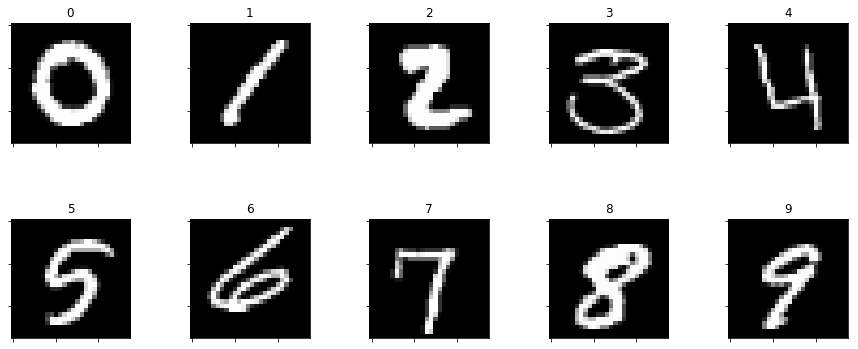

In [8]:
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
fig.subplots_adjust(hspace = .5, wspace=.5)
axs = axs.ravel()
for i in range(10):
    idx = train_data[train_data['label']==i].index[0]
    axs[i].imshow(X_train[idx][:,:,0], cmap='gray')
    axs[i].set_title(y_train[idx].argmax())
    axs[i].set_xticklabels([])
    axs[i].set_yticklabels([])

In [9]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.001, random_state=2020)

In [10]:
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

In [11]:
optimizer = RMSprop(lr=0.001,rho=0.9, epsilon=1e-08, decay=0.0)

In [12]:
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        25632     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)         

In [14]:
epochs = 50
batch_size = 378

In [15]:
datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=10,
        zoom_range = 0.1,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=False,
        vertical_flip=False)
datagen.fit(X_train)

In [16]:
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,y_val),
                              steps_per_epoch=X_train.shape[0] // batch_size)

Epoch 1/50
111/111 [==============================] - 15s 136ms/step - loss: 0.7165 - accuracy: 0.7625 - val_loss: 0.0105 - val_accuracy: 1.0000
Epoch 2/50
111/111 [==============================] - 14s 124ms/step - loss: 0.1907 - accuracy: 0.9427 - val_loss: 0.0046 - val_accuracy: 1.0000
Epoch 3/50
111/111 [==============================] - 13s 118ms/step - loss: 0.1248 - accuracy: 0.9627 - val_loss: 7.3452e-04 - val_accuracy: 1.0000
Epoch 4/50
111/111 [==============================] - 13s 119ms/step - loss: 0.1021 - accuracy: 0.9699 - val_loss: 0.0031 - val_accuracy: 1.0000
Epoch 5/50
111/111 [==============================] - 13s 120ms/step - loss: 0.0827 - accuracy: 0.9748 - val_loss: 3.4770e-04 - val_accuracy: 1.0000
Epoch 6/50
111/111 [==============================] - 13s 115ms/step - loss: 0.0740 - accuracy: 0.9778 - val_loss: 7.6556e-04 - val_accuracy: 1.0000
Epoch 7/50
111/111 [==============================] - 14s 124ms/step - loss: 0.0644 - accuracy: 0.9802 - val_loss: 1.0

In [17]:
y_test = model.predict(X_test)

In [18]:
y_test_classes = np.argmax(y_test, axis = 1)

In [19]:
num = range(1, len(y_test)+1)
output = pd.DataFrame({'ImageId': num,
                       'Label': y_test_classes})
output.to_csv('submission.csv', index=False)

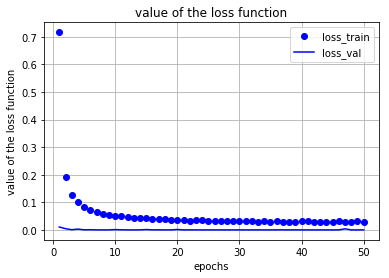

In [20]:
loss = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'bo', label='loss_train')
plt.plot(epochs, loss_val, 'b', label='loss_val')
plt.title('value of the loss function')
plt.xlabel('epochs')
plt.ylabel('value of the loss function')
plt.legend()
plt.grid()
plt.show()

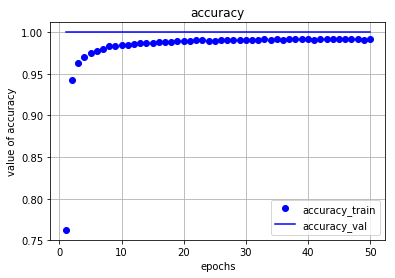

In [21]:
acc = history.history['accuracy']
acc_val = history.history['val_accuracy']
epochs = range(1, len(loss)+1)
plt.plot(epochs, acc, 'bo', label='accuracy_train')
plt.plot(epochs, acc_val, 'b', label='accuracy_val')
plt.title('accuracy')
plt.xlabel('epochs')
plt.ylabel('value of accuracy')
plt.legend()
plt.grid()
plt.show()

In [22]:
del model